In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
from os.path import abspath

from pyspark.sql.functions import isnan, when, count, col, lit
from pyspark import StorageLevel


In [2]:
# Choose the size of the dataset to load and analyze. Must be 'tiny', 'mini' or 'giga'
log_file_size = 'giga'


In [3]:
warehouse_location = abspath('spark-warehouse')

spark = SparkSession \
    .builder \
    .appName("sparkify-dea-"+log_file_size) \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .config("spark.driver.memory", "8g")\
    .enableHiveSupport() \
    .getOrCreate()


# Load and Explore the json data file

In [4]:
user_logs_hive_table  = log_file_size+"_user_logs_bin" 

In [11]:
%%time
# Load the different user logs file in Hive tables

def load_user_logs(log_file_size):

    user_log_files = {
        "tiny" : "data/sparkify_log_small.json",
        "mini" : "data/mini_sparkify_event_data.json",
        "giga" : "data/sparkify_event_data.json"
    }
    
    # Load file
    file_to_load = user_log_files[log_file_size]
    print("Loading file ",file_to_load)
    df_user_logs = spark.read.json(user_log_files[log_file_size])

    # Link DF to temp table
    temp_logs_table = log_file_size+"_user_logs_temp"
    print("Saving into temp table ",temp_logs_table)
    df_user_logs.createOrReplaceTempView(temp_logs_table)

    # Create Hive table with rows and some columns usefull for churn prediction  
    destination_logs_table = log_file_size+"_user_logs_bin" 
    print("Saving usefull logs into destination Hive table ",destination_logs_table)
    spark.sql("DROP TABLE IF EXISTS {}".format(destination_logs_table)).collect()
    sql_create_user_logs = """
        create table {DESTINATION_TABLE}
        USING parquet
        OPTIONS (header "true", inferSchema "true")
        PARTITIONED BY (userId)
        as
        (
            select 
                userId, itemInSession, length, page, sessionId, ts
            from {ORIGIN_TABLE}
            where 
                level = 'paid' and 
                userID != ''
            order by ts
        )
    """.format(**{
        'DESTINATION_TABLE' : destination_logs_table,
        'ORIGIN_TABLE' : temp_logs_table,
    })
    spark.sql(sql_create_user_logs).collect()

    return destination_logs_table

user_logs_hive_table = load_user_logs(log_file_size)

In [6]:
spark.sql("select * from {} limit 10".format(user_logs_hive_table)).toPandas().head(2)

,itemInSession,length,page,registration,sessionId,ts,userId
0,158,NaN,Home,NaN,230152,1543505724000,1261737
1,36,NaN,Home,NaN,235136,1543505730000,1261737


## List of 18 fields present in the original big data file

In [18]:
spark.sql(f"describe table {user_logs_hive_table}").show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|       artist|   string|   null|
|         auth|   string|   null|
|    firstName|   string|   null|
|       gender|   string|   null|
|itemInSession|   bigint|   null|
|     lastName|   string|   null|
|       length|   double|   null|
|        level|   string|   null|
|     location|   string|   null|
|       method|   string|   null|
|         page|   string|   null|
| registration|   bigint|   null|
|    sessionId|   bigint|   null|
|         song|   string|   null|
|       status|   bigint|   null|
|           ts|   bigint|   null|
|    userAgent|   string|   null|
|       userId|   string|   null|
+-------------+---------+-------+



## List of pages (~= actions) that took the users during the entire period

In [21]:
%%time
df_distinct_pages = spark.sql(f"select distinct(page) from {user_logs_hive_table}")
df_distinct_pages.show(100, truncate=False)


+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+

CPU times: user 4.32 ms, sys: 2.93 ms, total: 7.25 ms
Wall time: 22.9 s


***
# Store some usefull logs into a Hive table with data compression
I will focus on the fields and rows that:
- are related to an authentified paying user
- could not be used by features to discriminate users based on their ethny, gender, location...


## Explore the information in the main fields

### the tiny file "sparkify_log_small.json" 
- contains 10 K logs about 964 users
- The logs covers a period of 3 days between the 19 and the 21 of December 2017

### the mini file "mini_sparkify_event_data.json" 
- contains 222 K logs about 165 users
- The logs covers a period of 2 months between the first of October 2018 and the third of December 2018 

### the giga file "sparkify_event_data.json" 
- contains 2 M logs over 16185 users
- The logs covers a period of 2 months between the first of October 2018 and the third of December 2018 


In [7]:
sql_explore_ts = """
    select 
        a.nb_logs_total,
        from_unixtime(min_ts) min_dt, 
        from_unixtime(max_ts) max_dt,
        a.nb_users
    from 
    (
        select 
            count(*) nb_logs_total, 
            count(distinct(userId)) nb_users,
            min(ts/1000) min_ts, max(ts/1000) max_ts 
        from {USER_LOG_HIVE_TABLE}
    ) a
""".format(**{
    'USER_LOG_HIVE_TABLE' : user_logs_hive_table
    })

spark.sql(sql_explore_ts).show(truncate = False)


+-------------+-------------------+-------------------+--------+
|nb_logs_total|min_dt             |max_dt             |nb_users|
+-------------+-------------------+-------------------+--------+
|20595828     |2018-10-01 02:00:01|2018-12-01 00:59:59|16185   |
+-------------+-------------------+-------------------+--------+



***
# Agregate data by user

In [5]:
import time, datetime

default_evaluation_period_config = {
    "tiny" : { # the last one day of the 3 days logs
        "start_date_str" : "21/12/2017",
        "end_date_str" : "22/12/2018",
   },
    "mini" : { # the last two weeks of the 2 months logs
        "start_date_str" : "20/11/2018",
        "end_date_str" : "04/12/2018",
   },
    "giga" : { # the last two weeks of the 2 months logs
        "start_date_str" : "20/11/2018",
        "end_date_str" : "04/12/2018",
   }
}

In [6]:
# Convert the evaluation period start-stop to tms

user_logs_table = user_logs_hive_table
evaluation_period_config = default_evaluation_period_config

evaluation_start_date_str = evaluation_period_config[log_file_size]["start_date_str"]
evaluation_end_date_str = evaluation_period_config[log_file_size]["end_date_str"]

evaluation_start_dt = datetime.datetime.strptime(evaluation_start_date_str,"%d/%m/%Y") 
evaluation_start_tms = int(datetime.datetime.timestamp(evaluation_start_dt)) * 1000

evaluation_end_dt = datetime.datetime.strptime(evaluation_end_date_str,"%d/%m/%Y") 
evaluation_end_tms = int(datetime.datetime.timestamp(evaluation_end_dt)) * 1000

user_daily_logs_table = log_file_size + '_user_daily_logs_' + evaluation_start_date_str.replace('/','_')
user_churn_table = log_file_size + '_user_churn_' + evaluation_start_date_str.replace('/','_')
user_data_table = log_file_size + '_user_data_' + evaluation_start_date_str.replace('/','_')

***
### Generate a variable SQL code instead of using heavier UDF 
A list of pages was created to represent the actions that the users took and that can be related to Churn.  
For each element of this list, parts of the SQL statement will be generated to have some features in the final user table (ex: count and average time the user as for a song or add a friend) 

In [9]:
pages_of_interest = ['NextSong', 'Thumbs Up', 'Add to Playlist', 'Add Friend', 'Downgrade',\
                     'Thumbs Down', 'Help', 'Save Settings', 'Error', 'Submit Downgrade']  

list_test_metrics_of_interest = [] 
list_count_metrics_of_interest = [] 
for poi in pages_of_interest:
    k = poi.replace(' ','')
    list_test_metrics_of_interest.append(f" if(page='{poi}',1,0) is_{k}")
    list_count_metrics_of_interest.append(f"sum(is_{k}) nb_{k}")
    
str_test_metrics_of_interest = ", ".join(list_test_metrics_of_interest)
str_count_metrics_of_interest = ", ".join(list_count_metrics_of_interest)

***
### Create a table with information of daily activities of the users based only on the logs previous to the evaluation period
This table creation use an SQL injection technique for the variable parts pf the statements.  
The use of UDF was discarded this time for performance concerns

In [34]:
%%time

spark.sql("DROP TABLE IF EXISTS {}".format(user_daily_logs_table)).collect()                            

sql_create_user_daily_logs = """
    create table {USER_DAILY_LOGS_TABLE} 
        USING parquet
        PARTITIONED BY (userId)
    as (
        select
            userId, days_before_eval, count(*) nb_logs, 
            count(distinct(sessionId)) nb_sessionId,
            sum(int(length)) sum_length,
            {COUNT_METRICS_OF_INTEREST}
        from 
        (
            select *,
            int(({EVALUATION_START_TS} - ts)/86400000) days_before_eval,
            {TEST_METRICS_OF_INTEREST}
            from {LOG_TABLE}
            where ts <= {EVALUATION_START_TS}
        ) a
        group by userId, days_before_eval
        order by userId, days_before_eval desc
    )
""".format(**{
        "EVALUATION_START_TS" : evaluation_start_tms, 
        "USER_DAILY_LOGS_TABLE" : user_daily_logs_table,
        "LOG_TABLE" : user_logs_table,
        "TEST_METRICS_OF_INTEREST" : str_test_metrics_of_interest,
        "COUNT_METRICS_OF_INTEREST" : str_count_metrics_of_interest
    })
print(sql_create_user_daily_logs)
ret_sql_user_daily_logs = spark.sql(sql_create_user_daily_logs).collect()

spark.sql("select * from {} limit 10".format(user_daily_logs_table)).toPandas().head(5)


    create table giga_user_daily_logs_20_11_2018 
        USING parquet
        PARTITIONED BY (userId)
    as (
        select
            userId, days_before_eval, count(*) nb_logs, 
            count(distinct(sessionId)) nb_sessionId,
            sum(int(length)) sum_length,
            sum(is_NextSong) nb_NextSong, sum(is_ThumbsUp) nb_ThumbsUp, sum(is_AddtoPlaylist) nb_AddtoPlaylist, sum(is_AddFriend) nb_AddFriend, sum(is_Downgrade) nb_Downgrade, sum(is_ThumbsDown) nb_ThumbsDown, sum(is_Help) nb_Help, sum(is_SaveSettings) nb_SaveSettings, sum(is_Error) nb_Error, sum(is_SubmitDowngrade) nb_SubmitDowngrade
        from 
        (
            select *,
            int((1542668400000 - ts)/86400000) days_before_eval,
             if(page='NextSong',1,0) is_NextSong,  if(page='Thumbs Up',1,0) is_ThumbsUp,  if(page='Add to Playlist',1,0) is_AddtoPlaylist,  if(page='Add Friend',1,0) is_AddFriend,  if(page='Downgrade',1,0) is_Downgrade,  if(page='Thumbs Down',1,0) is_ThumbsDown,  if(page=

,days_before_eval,nb_logs,nb_sessionId,sum_length,nb_NextSong,nb_ThumbsUp,nb_AddtoPlaylist,nb_AddFriend,nb_Downgrade,nb_ThumbsDown,nb_Help,nb_SaveSettings,nb_Error,nb_SubmitDowngrade,userId
0,49,281,2,59114,228,11,7,2,2,1,2,0,0,0,1564221
1,48,156,3,34649,133,5,3,5,1,1,3,0,1,0,1564221
2,47,355,1,72250,286,19,12,12,3,3,1,0,0,0,1564221
3,46,298,1,63255,255,11,6,9,0,1,3,0,0,0,1564221
4,45,269,5,53160,225,11,7,1,5,3,0,0,0,0,1564221


In [39]:
# Number of users-days entries is 250 K. 
# We are starting to get a dataset manageable by 'classic' ml libraries and work stations

spark.sql("select count(*) nb_entries from {}".format(user_daily_logs_table)).show(10)

+----------+
|nb_entries|
+----------+
|    248995|
+----------+



***
# Days of activity that we have available for each user
For most users we have less than 20 days of data for the two months period 

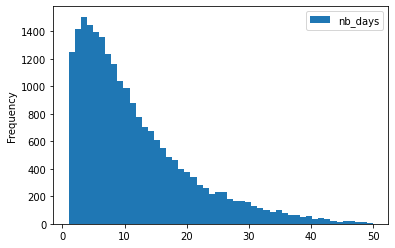

In [60]:

df_days_of_activity_by_user = spark.sql("select userId, count(*) nb_days from {} group by userId".format(user_daily_logs_table))
df_days_of_activity_by_user.persist()
pdf_days_of_activity_by_user = df_days_of_activity_by_user.toPandas()

pdf_days_of_activity_by_user.plot.hist(bins=50);

***
# Active users per day
- We have between 3 K and 6K of daily active users.
- During the two months, we have lost almost 2 K of maximum active users per day 
- The active users double between different days of the week 

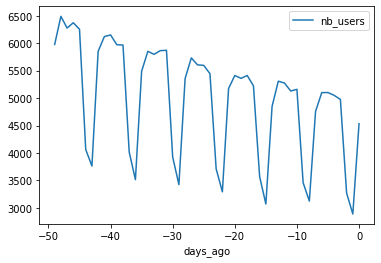

In [68]:
df_active_users_per_day = spark.sql("select (- days_before_eval) days_ago, count(*) nb_users from {} group by days_before_eval order by days_before_eval".format(user_daily_logs_table))
pdf_active_users_per_day = df_active_users_per_day.toPandas()
pdf_active_users_per_day.plot(x='days_ago', y='nb_users');

***
### Users leave regularly the service
We have between 75 and 175 users leaving or downgrading their service every day.  
It seems stable.  
Note: A user that downgrade or leave on day X and downgrade or leave on days X+b will be considered twice in this visualization


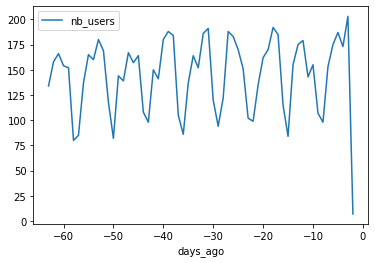

In [90]:
sql_user_churn_per_day = """

    select 
        days_ago, count(*) nb_users
    from
    (
        select userID,
        max(int( (ts - {EVALUATION_START_TS} - (14*86400000))/86400000)) days_ago
        from {LOG_TABLE}
        where 
            page in('Cancellation Confirmation', 'Submit Downgrade')
        group by userId

    ) group by days_ago
    order by days_ago
""".format(**{
        "EVALUATION_START_TS" : evaluation_start_tms,
        "EVALUATION_END_TS" : evaluation_end_tms,
        "LOG_TABLE" : user_logs_table
    })

df_user_churn_per_day = spark.sql(sql_user_churn_per_day)
pdf_user_churn_per_day = df_user_churn_per_day.toPandas()


pdf_user_churn_per_day.plot(x='days_ago', y='nb_users');

***
### Create a table with all the userID that will cancel or downgrade their contract during the evaluation period

In [7]:
%%time
spark.sql("DROP TABLE IF EXISTS {}".format(user_churn_table)).collect()                            

sql_create_user_churn = """
    create table {USER_CHURN_TABLE} 
        USING parquet
        PARTITIONED BY (userId)
    as (
        select userID,  1 churn
        from {LOG_TABLE}
        where 
            page in('Cancellation Confirmation', 'Submit Downgrade')
            and ts between {EVALUATION_START_TS} and {EVALUATION_END_TS}
        group by userId
        )
""".format(**{
        "EVALUATION_START_TS" : evaluation_start_tms,
        "EVALUATION_END_TS" : evaluation_end_tms,
        "USER_CHURN_TABLE" : user_churn_table,
        "LOG_TABLE" : user_logs_table
    })

ret_sql_user_daily_logs = spark.sql(sql_create_user_churn).collect()

CPU times: user 39.8 ms, sys: 16.2 ms, total: 56.1 ms
Wall time: 4min 59s


### Generate a variable SQL code instead of using heavier UDF 

In [8]:
pages_of_interest = ['NextSong', 'Thumbs Up', 'Add to Playlist', 'Add Friend', 'Downgrade',\
                     'Thumbs Down', 'Help', 'Save Settings', 'Error', 'Submit Downgrade', 'logs']  

list_user_stats_on_metrics_of_interest = [] 
for poi in pages_of_interest:
    k = poi.replace(' ','')
    list_user_stats_on_metrics_of_interest.append(f" sum(nb_{k}) sum_nb_{k}, avg(nb_{k}) avg_nb_{k}, avg(nb_{k}/nb_logs) avg_pct_{k}  ")
        
str_user_stats_on_metrics_of_interest = ", ".join(list_user_stats_on_metrics_of_interest)

***
### Create a table with all the user information agregated in one row per user, including the churn label

In [9]:
%%time
spark.sql("DROP TABLE IF EXISTS {}".format(user_data_table)).collect()                            

sql_create_user_data = """
    create table {USER_DATA_TABLE} 
        USING parquet
    as (
            select 
                l.*, 
                nvl(c.churn, 0) as churn,
                (active_days / max_days_before_eval) as avg_active_days
           from
            (
                select dl.userId, 
                (max(days_before_eval)+1) max_days_before_eval,
                count(days_before_eval) active_days,
                avg(nb_sessionId) avg_nb_session_per_day,
                avg(nvl(sum_length,0)) avg_length_per_day,
                avg(nvl(sum_length,0) / nb_sessionId) avg_length_per_session,
                {DAILY_STATS_ON_METRICS_OF_INTEREST}
                from {USER_DAILY_LOGS_TABLE} dl
                group by userId
            ) as l left join {USER_CHURN_TABLE} c on l.userId = c.userId
        )
""".format(**{
        "USER_DATA_TABLE" : user_data_table,
        "USER_DAILY_LOGS_TABLE" : user_daily_logs_table,
        "USER_CHURN_TABLE" : user_churn_table,
        "DAILY_STATS_ON_METRICS_OF_INTEREST" : str_user_stats_on_metrics_of_interest
    
    })

ret_sql_create_user_data = spark.sql(sql_create_user_data).collect()
spark.sql("select * from {}".format(user_data_table)).toPandas().head()


CPU times: user 368 ms, sys: 64.6 ms, total: 433 ms
Wall time: 1min 14s


,userId,max_days_before_eval,active_days,avg_nb_session_per_day,avg_length_per_day,avg_length_per_session,sum_nb_NextSong,avg_nb_NextSong,avg_pct_NextSong,sum_nb_ThumbsUp,...,avg_nb_Error,avg_pct_Error,sum_nb_SubmitDowngrade,avg_nb_SubmitDowngrade,avg_pct_SubmitDowngrade,sum_nb_logs,avg_nb_logs,avg_pct_logs,churn,avg_active_days
0,1169050,50,41,1.487805,31062.292683,24612.613821,5139,125.341463,0.821971,274,...,0.121951,0.000509,1,0.024390,0.000400,6147,149.926829,1.0,0,0.820000
1,1105878,50,40,1.350000,26677.750000,22427.400000,4279,106.975000,0.831642,191,...,0.100000,0.000510,1,0.025000,0.000115,5051,126.275000,1.0,1,0.800000
2,1660035,50,37,1.378378,26552.000000,20413.504505,3974,107.405405,0.794230,201,...,0.189189,0.000785,1,0.027027,0.000106,4731,127.864865,1.0,0,0.740000
3,1824042,50,39,1.410256,20807.666667,14984.153846,3251,83.358974,0.810777,315,...,0.076923,0.001261,0,0.000000,0.000000,3994,102.410256,1.0,1,0.780000
4,1355031,49,35,1.542857,35868.457143,27270.254762,5031,143.742857,0.819464,241,...,0.200000,0.000822,2,0.057143,0.000394,5995,171.285714,1.0,1,0.714286


# Evaluation period
- The evaluation period is the one during which we are going to predict the cancelation
- A table was created to list the users for which we have some logs and the Cancellation could be predicted

### the giga file "sparkify_event_data.json" 
- During the evaluation period between the 20/11/2018 and the 04/12/2018, 1512 (10%) of the 15349 users will Cancel their contract or downgrade to a free one.


We need know to build the features one the user level that could predict that event. 

In [10]:
sql_check_cancellation = "select churn, count(*) nb_users from {} group by churn".format(user_data_table)

df_check_cancellation = spark.sql(sql_check_cancellation)
df_check_cancellation.show()


+-----+--------+
|churn|nb_users|
+-----+--------+
|    1|    1593|
|    0|   20450|
+-----+--------+

